## VAE LSTM Training

In [1]:
%load_ext autoreload
%autoreload 2

from Pytorch_VAE_LSTM import VAE
from dataset.modules.music_dataset import TorchMusicDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from scipy.io.wavfile import write


dataset = TorchMusicDataset("./dataset/cleaned_data/cleaned_data")

In [2]:
songs = []
for i in range(700):
    obj = dataset.__getitem__(i)
    song = obj['time_series'].numpy()[:-7]
    reduce_mean_song = np.mean(song.reshape(-1, 40), axis=1) 
    songs.append(reduce_mean_song.reshape(reduce_mean_song.shape[0], 1))

In [3]:
songs[0].shape

(33049, 1)

In [4]:
batch_size = 16
n_in = songs[0].shape[0]
hidden_size = 10
songs = np.array(songs)
songs = torch.tensor(songs, dtype=torch.float32)

dataset = TensorDataset(songs, songs) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE(timesteps=n_in, features=1, latent_dim=4, device=device, hidden_size=hidden_size).to(device)
vae.optimizer = optim.Adam(vae.parameters(), lr=1e-3)

lossGraph = []

# Training loop
epochs = 300
for epoch in range(epochs):
    for batch_x, _ in dataloader:
        batch_x = batch_x.to(device)
        loss = vae.training_step(batch_x)
    if epoch % 10 == 0:
        lossGraph.append(loss)
        print(f'Epoch {epoch}, Loss: {loss}')
    
num_samples = 1
generated_sequences = vae.generate_sequences(num_samples)

Epoch 0, Loss: 0.035412512719631195
Epoch 10, Loss: 0.049096252769231796
Epoch 20, Loss: 0.032688651233911514
Epoch 30, Loss: 0.02611473575234413
Epoch 40, Loss: 0.029987361282110214
Epoch 50, Loss: 0.02601584792137146
Epoch 60, Loss: 0.030184803530573845
Epoch 70, Loss: 0.03017347864806652
Epoch 80, Loss: 0.03128492832183838
Epoch 90, Loss: 0.034602656960487366
Epoch 100, Loss: 0.04313110560178757
Epoch 110, Loss: 0.03356746956706047
Epoch 120, Loss: 0.034140922129154205
Epoch 130, Loss: 0.05863659456372261
Epoch 140, Loss: 0.028810380026698112
Epoch 150, Loss: 0.02468167617917061
Epoch 160, Loss: 0.05508603900671005
Epoch 170, Loss: 0.040078308433294296
Epoch 180, Loss: 0.031061621382832527
Epoch 190, Loss: 0.04186679422855377
Epoch 200, Loss: 0.05133196711540222
Epoch 210, Loss: 0.011543664149940014
Epoch 220, Loss: 0.026098813861608505
Epoch 230, Loss: 0.02816999889910221
Epoch 240, Loss: 0.02676655538380146
Epoch 250, Loss: 0.022356543689966202
Epoch 260, Loss: 0.02822593040764331

In [25]:
torch.save(vae, 'VAE_LSTM.pt')

In [5]:
lossGraph = np.array(lossGraph)
np.save('loss_LSTM_VAE.npy', lossGraph)

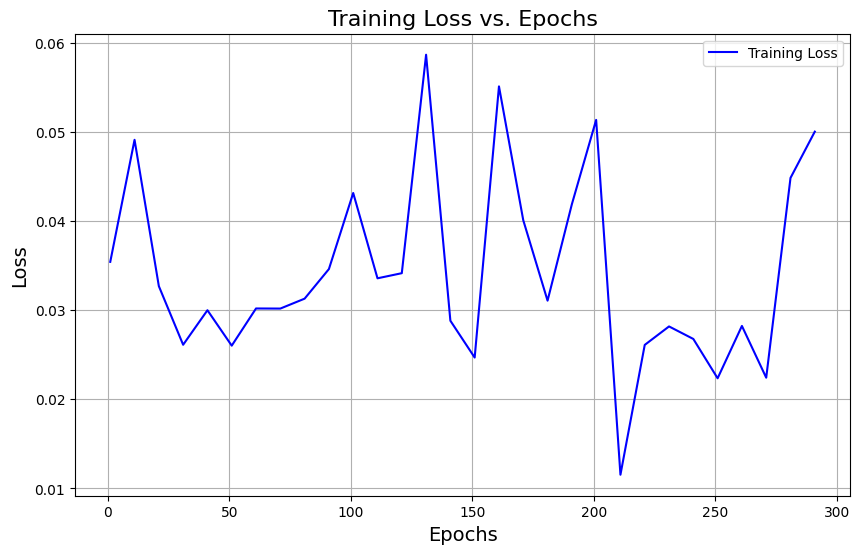

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1,300,10), lossGraph, linestyle='-', color='b', label='Training Loss')

plt.title('Training Loss vs. Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.grid(True)

plt.show()

## Hyperparameter Search

In [9]:
searchLoss = {}
hidden_sizes = [1, 10, 20]
latent_dims = [2, 4, 8]

for hidden_size in hidden_sizes:
    for latent_dim in latent_dims:
        vae = VAE(timesteps=n_in, features=1, latent_dim=latent_dim, device=device, hidden_size=hidden_size).to(device)
        vae.optimizer = optim.Adam(vae.parameters(), lr=1e-3)
        
        # Training loop
        lossGraph = []
        for epoch in range(100):
            for batch_x, _ in dataloader:
                batch_x = batch_x.to(device)
                loss = vae.training_step(batch_x)
            
            if epoch % 10 == 0:
                lossGraph.append(loss)
                print(f'Hidden Size: {hidden_size}, Latent Dim: {latent_dim}, Epoch {epoch}, Loss: {loss}')
        
        searchLoss[(hidden_size, latent_dim)] = lossGraph
        print('****************************** END OF TRIAL ******************************')

Hidden Size: 1, Latent Dim: 2, Epoch 0, Loss: 0.38172340393066406
Hidden Size: 1, Latent Dim: 2, Epoch 10, Loss: 0.05157022923231125
Hidden Size: 1, Latent Dim: 2, Epoch 20, Loss: 0.036733198910951614
Hidden Size: 1, Latent Dim: 2, Epoch 30, Loss: 0.034321919083595276
Hidden Size: 1, Latent Dim: 2, Epoch 40, Loss: 0.033613357692956924
Hidden Size: 1, Latent Dim: 2, Epoch 50, Loss: 0.0245741568505764
Hidden Size: 1, Latent Dim: 2, Epoch 60, Loss: 0.030418025329709053
Hidden Size: 1, Latent Dim: 2, Epoch 70, Loss: 0.017593244090676308
Hidden Size: 1, Latent Dim: 2, Epoch 80, Loss: 0.04911850765347481
Hidden Size: 1, Latent Dim: 2, Epoch 90, Loss: 0.021836264058947563
****************************** END OF TRIAL ******************************
Hidden Size: 1, Latent Dim: 4, Epoch 0, Loss: 0.800121545791626
Hidden Size: 1, Latent Dim: 4, Epoch 10, Loss: 0.19920924305915833
Hidden Size: 1, Latent Dim: 4, Epoch 20, Loss: 0.08060810714960098
Hidden Size: 1, Latent Dim: 4, Epoch 30, Loss: 0.0395

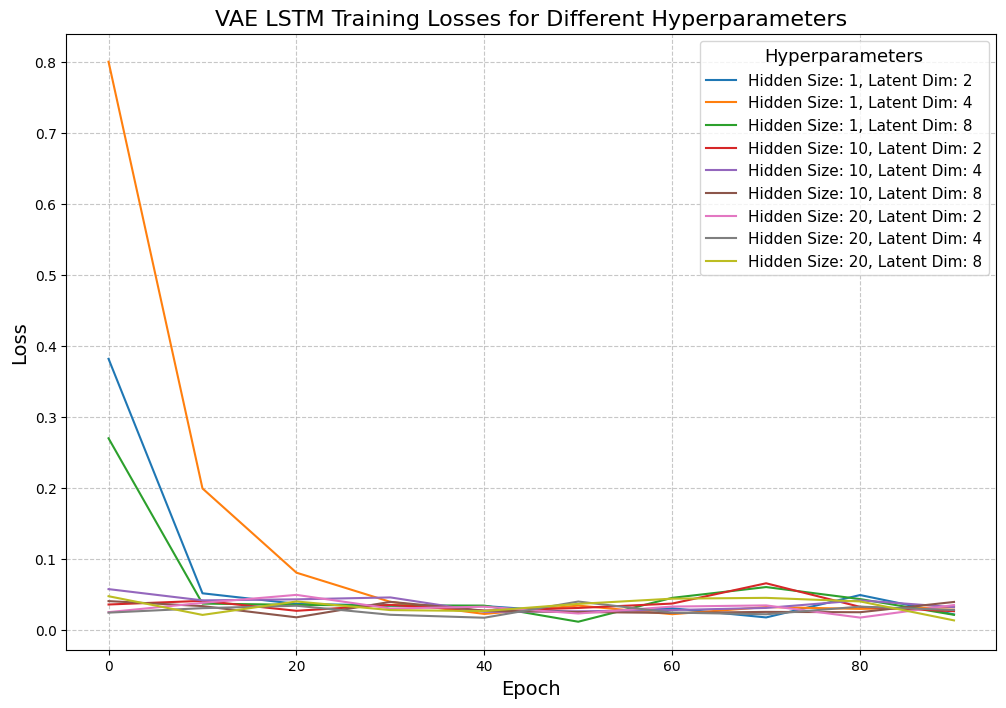

In [13]:
plt.figure(figsize=(12, 8))

for (hidden_size, latent_dim), losses in searchLoss.items():
    plt.plot(np.arange(0, 100, 10), losses, label=f'Hidden Size: {hidden_size}, Latent Dim: {latent_dim}')

plt.title('VAE LSTM Training Losses for Different Hyperparameters', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(title='Hyperparameters', title_fontsize='13', fontsize='11')

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## Generation of Audio

In [10]:
reconstructed_songs = []
for sequence in generated_sequences:
    reconstructed_song = np.repeat(sequence, 40, axis=0)
    reconstructed_songs.append(reconstructed_song)

In [12]:
reconstructed_songs[0]

array([-1.0124829e-06, -1.0124829e-06, -1.0124829e-06, ...,
       -3.6045098e-01, -3.6045098e-01, -3.6045098e-01], dtype=float32)

In [24]:
audio_array = reconstructed_songs[0] 
sample_rate = 44100 

audio_array = audio_array / np.max(np.abs(audio_array))

audio_array = (audio_array * 32767).astype(np.int16)

output_filename = 'gen_audio_VAE_LSTM.wav'
write(output_filename, sample_rate, audio_array)

print(f"Audio saved as {output_filename}")

Audio saved as output_audio.wav
